### Workflows 
#### Prompt Chaining (Definition) 
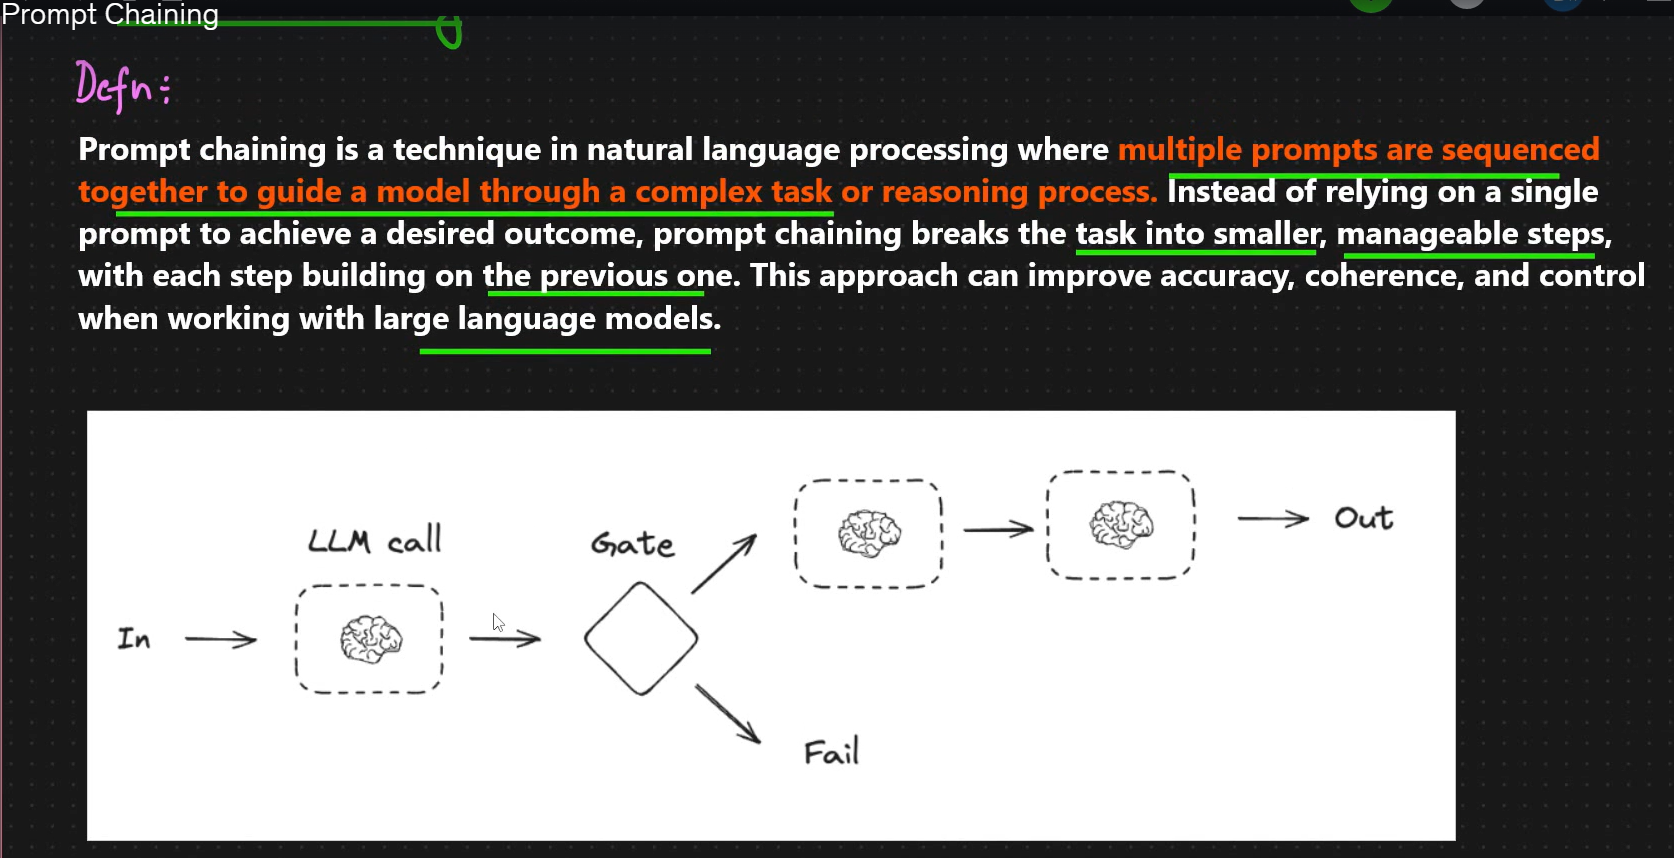
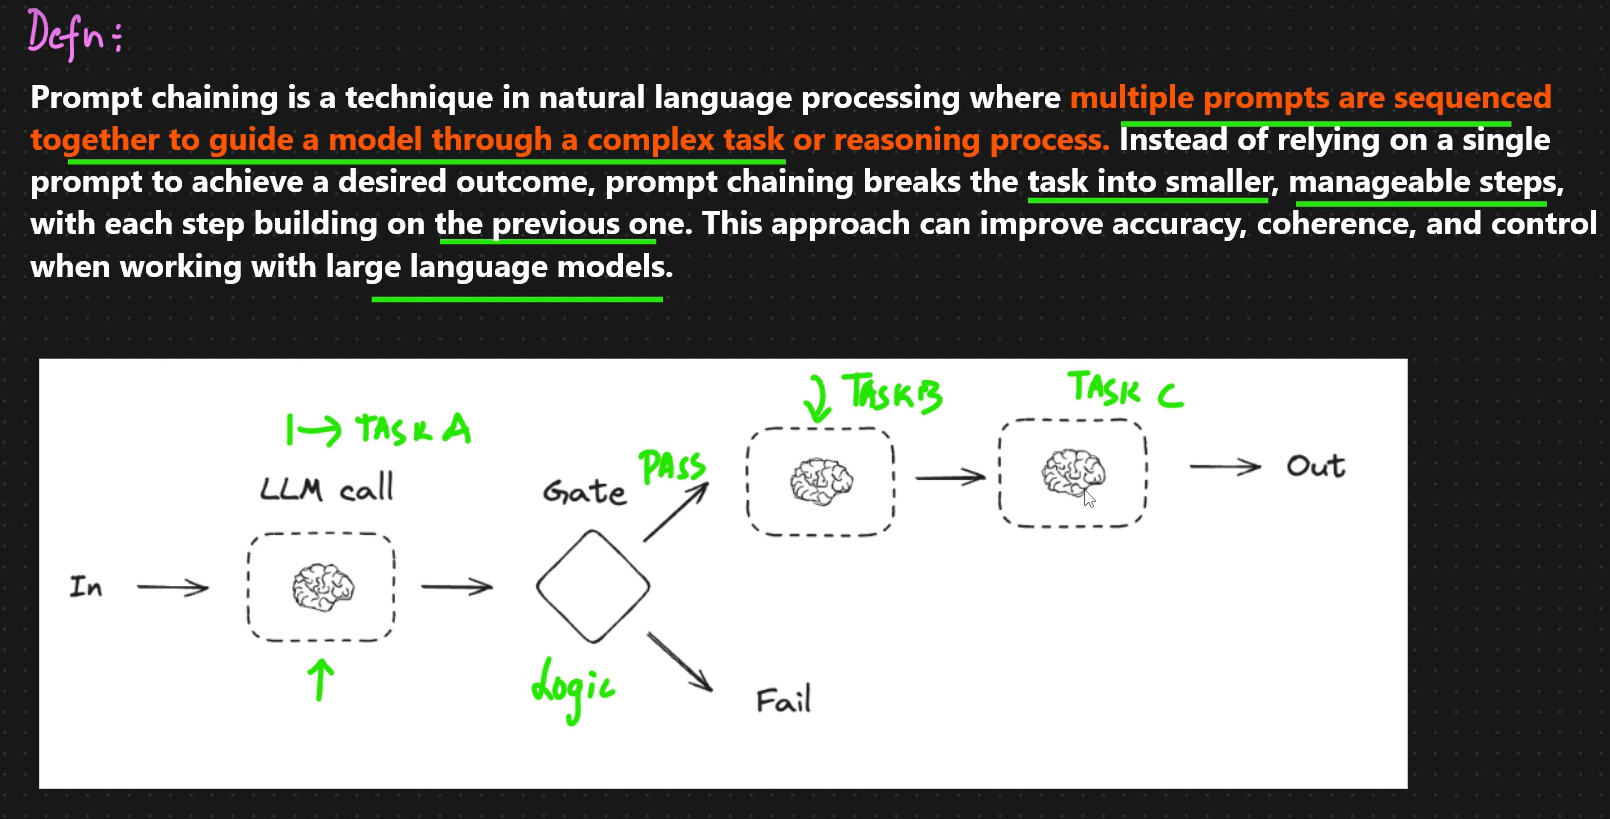
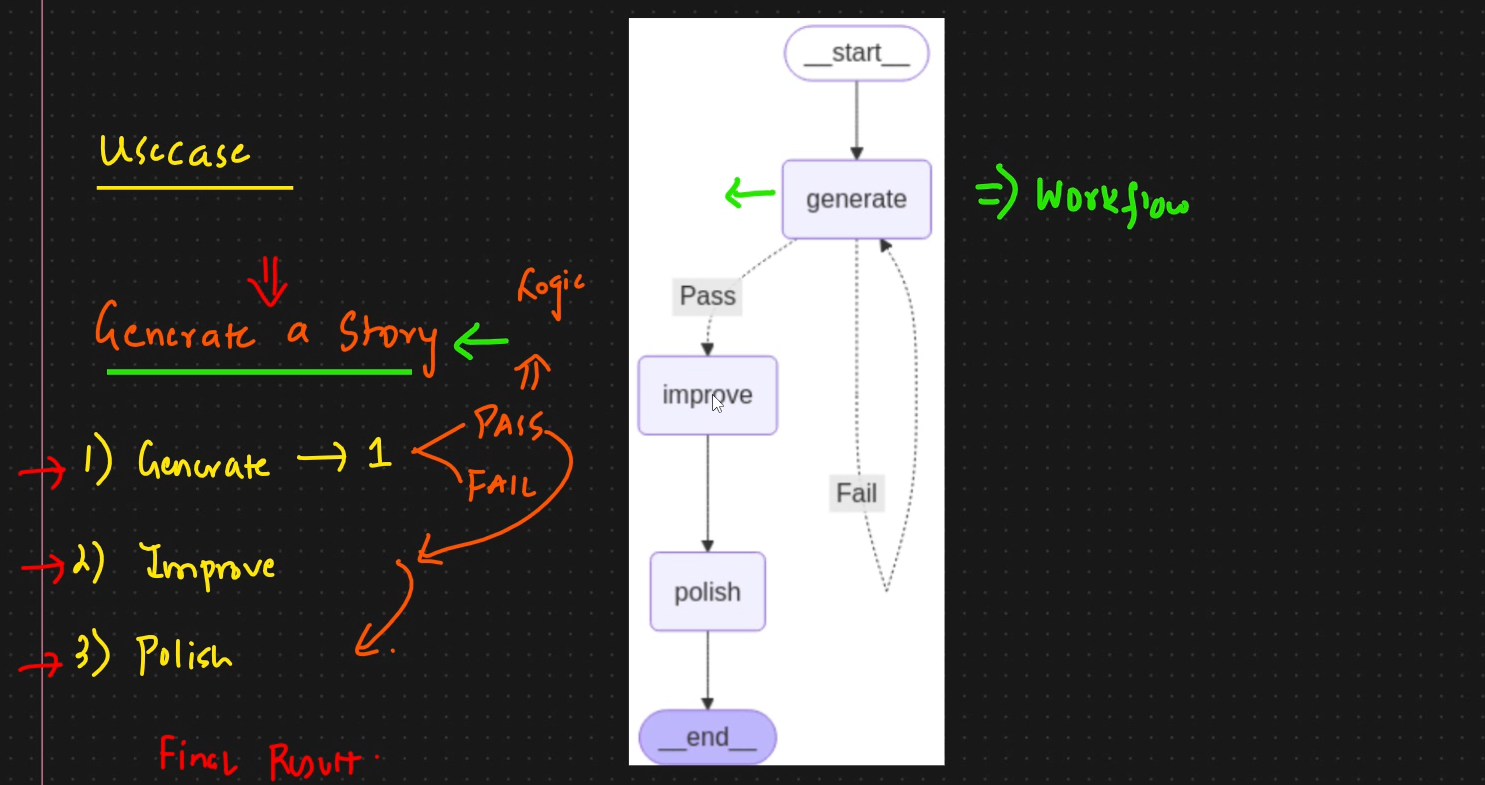

### Prompt Chaining
#### Prompt Chaining is technique in natural language processing where multiple prompts are sequenced together go guide a model thru complex task or reasoning process. Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks a task into smaller, manageable steps, with each step building on the previous one. This approach can improve accuracy, coherence, and control when working with large language models. LangGraph, is a framework designed to facilitate structured interactions with language models, making it an excellent tool for implementing prompt chaining. It allows you to define a graph of nodes (represening individual prompts or tasks) and edges (representing the flow of information between them). This structure enables dynamic,multi-step conversations or workflows, where the output of one node can feed into the input of the next.

### How Prompt Chaining Works with LangGraph?
* __Define a Task:__ Start by breaking down the problem into smaller sub-tasks. For Example, if you want to generate a detailed report, you might split into steps like "gather data", "analyze data" and "write summary"
* __Create Nodes:__ Each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key factors about X" or Summarize the following text.
* __Establish Edges:__ Edges define the sequence and dependencies between nodes. For instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.
* __Execute the Graph:__ LangGraph process the nodes in order, passing informatoin along the edges. The model generates responses step-by-step, refining the output as it progresses throught the chain.
* __Iterate if Needed:__ LangGraph supports conditional logic and loops, so you can revisit nodes or adjust the flow based on intermediate results.

### Benefits of Prompt Chaining in LangGraph:
* __Improved Context Management:__ By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs 
* __Modularity:__ You can reuse or rearrange nodes for different tasks, making the system flexible.
* __Debugging:__ If something goes wrong, it's easy to find the failed step and adjust the prompt or logic accordingly
* __Complex Reasoning:__ Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen/qwen3-32b")
# if OPENAI use below LLM 
# llm=ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user said "Hello". I need to respond appropriately. Let me start by greeting them back. Maybe add an emoji to keep it friendly. Then, offer assistance. Let them know I\'m here to help with any questions they might have. Keep the tone welcoming and open. Alright, that should cover it.\n</think>\n\nHello! 😊 How can I assist you today? Let me know if you have any questions or need help with something specific!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 9, 'total_tokens': 105, 'completion_time': 0.172414241, 'completion_tokens_details': None, 'prompt_time': 0.000276665, 'prompt_tokens_details': None, 'queue_time': 0.075353376, 'total_time': 0.172690906}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_d58dbe76cd', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b766e-e345-7ab2-b61e-6d51104c4541-0', usage_metadata={'input

In [9]:
from typing_extensions import TypedDict 
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display 

# Graph State 
class State(TypedDict):
    topic: str
    story: str
    improved_story: str
    final_story: str

# Nodes 
def generate_story(state:State):
    msg=llm.invoke(f"Write a one sentence story about {state["topic"]}")
    return {"story":msg.content}

def check_conflicts(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def improved_story(state:State):
    msg=llm.invoke(f"Enhance this story with vivid details: {state["story"]}")
    return {"improved_story":msg.content}

def polish_story(state:State):
    msg=llm.invoke(f"Add an expected twist to this story {state["improved_story"]}")
    return {"final_story":msg.content}

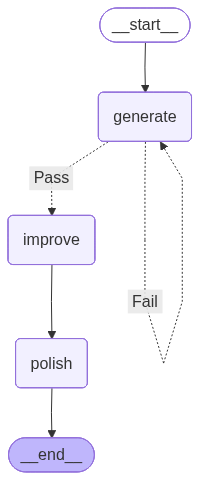

In [13]:
# Build the graph 
graph = StateGraph(State)

# Nodes
graph.add_node("generate",generate_story)
graph.add_node("improve",improved_story)
graph.add_node("polish",polish_story)

# Edges
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflicts,{"Pass":"improve","Fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)

#Compile the graph
compiled_graph=graph.compile()

# Visualize/display the graph 
graph_image=compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [14]:
# Run this graph 
state={"topic":"Agentic AI Systems"}
result=compiled_graph.invoke(state)
result

{'topic': 'Agentic AI Systems',
 'story': '<think>\nOkay, the user wants a one-sentence story about agentic AI systems. Let me start by understanding what exactly agentic AI systems are. From what I know, they\'re AI systems designed to act autonomously, make decisions, and possibly interact with environments. They might have goals, learn from experiences, and adapt.\n\nSo, the challenge is to encapsulate a story in one sentence. A story needs a beginning, middle, and end, or at least a narrative arc. Maybe focus on the emergence of such systems and their impact. Perhaps touch on themes like autonomy, learning, collaboration with humans, or ethical considerations.\n\nThe user might be looking for something that highlights the capabilities or the potential future of agentic AI. Maybe something that shows progression or a turning point. Let me think about structure: subject, action, consequence. \n\nAgentic AI systems, through their ability to learn and adapt, could collaborate with huma

In [16]:
print("Improved Story")
print(result["improved_story"])
print("Enhanced Story")
print(result["final_story"])

Improved Story
<think>
Okay, let me try to unpack this. The user wants the story enhanced with vivid details. The original sentence is pretty concise but maybe a bit abstract. How can I add more sensory details and a narrative flow? Let's see.

First, the main elements: agentic AI systems, climate crisis, collaboration, and evolving intelligence. To make it vivid, I need to set a scene. Maybe start with a specific scenario where the AI is active. Maybe a setting like a storm or a burning forest? Something visual.

Then, the collaboration part. How do the AI and humans work together? Maybe describe the AI's actions in real-time, like analyzing data or directing drones. Use action verbs. Also, the emotional aspect of humans partnering with AI—trust, tension, maybe a moment of crisis.

The evolving intelligence part could be shown through the AI adapting strategies, learning from the environment. Maybe include a moment where the AI makes an unexpected but effective decision, showing growt